In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# from tqdm import tqdm_notebook,trange
import numba
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.decomposition import PCA
import math
from matplotlib.patches import Ellipse
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib
from tqdm import trange, notebook
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

In [ ]:
notebook.tqdm.pandas()

In [ ]:
store_path_base = r"/raid6/roozbeh/trip_similarity/"
data_path_base = r"../data/"
morning_df_parquet_name = r"koln_morning_dataframe.parquet"

In [ ]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, morning_df_parquet_name))

In [ ]:
morningdf_no_nan

In [ ]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [ ]:
morning50df = pd.read_parquet(os.path.join(data_path_base,r'morning_trips_df_with_50points.parquet'))

In [ ]:
morning50df

In [ ]:
morning50df.time = (morning50df.time - tmin)/(tmax - tmin)

In [ ]:
morning50df

## PLOTTING CONFIG

In [ ]:
mpl.rc('text', usetex=True)
# matplotlib.use('Agg')
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter',
                                  'DejaVu Sans Mono',
                                  'Bitstream Vera Sans Mono',
                                  'Courier']
sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']
# cyc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# matplotlib.rcParams.update({'font.size': 20,'xtick.labelsize':30,'ytick.labelsize':30})

---------

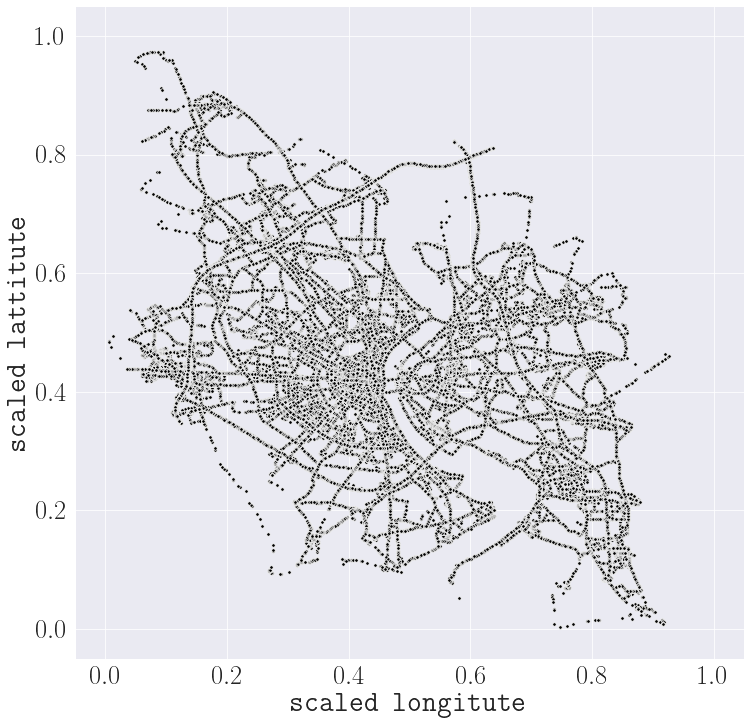

In [95]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = sample50df.x,y=sample50df.y, color='black', alpha=1, s=49, marker='.')
# sns.scatterplot(x = sample50df['orig x'],y=sampleODdf['orig y'], color='black', alpha=1, marker='x', s=30, label='trip origins')
# sns.scatterplot(x = sample50df['dest x'],y=sampleODdf['dest y'], color='red', alpha=0.4, s=12, label='trip destination')
plt.ylim((-0.05,1.05))
plt.xlim((-0.05,1.05))
plt.ylabel('scaled lattitute')
plt.xlabel('scaled longitute');

To use the same sample of trips as clustering with OD (for the sake of compatibility) let's load the same and take its trip_ids

In [ ]:
sampleODdf = pd.read_parquet(os.path.join(data_path_base, 'morning_sampleODdf.parquet'))

In [ ]:
sample50df = morning50df[morning50df.index.isin(sampleODdf.index)]

In [ ]:
sample50df

In [ ]:
174600//50

------

#### Defining distance/similarity

In [ ]:
import numba 
from numba import jit

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=True)
def get_wgm_similarity_50pt(arr1, arr2, w_x = 0.5, w_t = 0.5):
    '''
        arr1 and arr2 shape must be (50, 5) as in the DF.values 
    '''
#     if w_x + w_t != 1:
#         raise Exception("sum of w_x and w_t must be 1")
#     if len(df1) != 50 or len(df2) != 50:
#         raise Exception('df1 or df2 has a none 50 length')
        
    pairwise_dists = np.sqrt( np.square(arr1[:,2] - arr2[:,2]) + np.square(arr1[:,3] - arr2[:,3]) )
    pairwise_times = np.absolute(arr1[:,1] - arr2[:,1])
    pairwise_similarities = np.exp(w_x * np.log(1./(1+pairwise_dists)) + w_t * np.log(1./(1+pairwise_times)) )
    
    return np.mean(pairwise_similarities)

##### Let's try getting an affinity matrix

In [ ]:
# trip_ids = sample50df.groupby('trip_id').apply(lambda x : 1).index.values

In [ ]:
# trip_ids

In [ ]:
trip_ids, groups = zip(*list(sample50df.groupby('trip_id')))
trip_id_to_index = {trip_ids[i]:i for i in range(len(trip_ids))}

In [66]:
np.array(trip_ids).shape

(3492,)

In [50]:
groups_values = [group.values for group in groups]

In [58]:
groups_values_array = np.array(groups_values)

In [59]:
groups_values_array.shape

(3492, 50, 5)

In [ ]:
for i in range(len(trip_ids)):
    if trip_id_to_index[trip_ids[i]] != i:
        print("holler")

No holler means we can just go by index and place them into the matrix

In [90]:
@numba.jit(nopython=True)
def get_sim_matrix(trip_ids_array, groups_values_array):
    n = len(trip_ids)
    sim_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
    #         idx1 = trip_id_to_index[trip_ids[i]]
    #         idx2 = trip_id_to_index[trip_id2]
            sim_matrix[i,j] = get_wgm_similarity_50pt(groups_values_array[i], groups_values_array[j])
            sim_matrix[j,i] = sim_matrix[i,j] #symmetric
    return sim_matrix

In [91]:
%%time
sim_matrix = get_sim_matrix(np.array(trip_ids), groups_values_array)

Wall time: 1min 23s


In [92]:
sim_matrix

array([[1.        , 0.92880962, 0.84430837, ..., 0.86961918, 0.85239662,
        0.77947504],
       [0.92880962, 1.        , 0.89200555, ..., 0.83147014, 0.80707184,
        0.7936121 ],
       [0.84430837, 0.89200555, 1.        , ..., 0.84427957, 0.75061919,
        0.7236209 ],
       ...,
       [0.86961918, 0.83147014, 0.84427957, ..., 1.        , 0.77431371,
        0.69986718],
       [0.85239662, 0.80707184, 0.75061919, ..., 0.77431371, 1.        ,
        0.75753267],
       [0.77947504, 0.7936121 , 0.7236209 , ..., 0.69986718, 0.75753267,
        1.        ]])

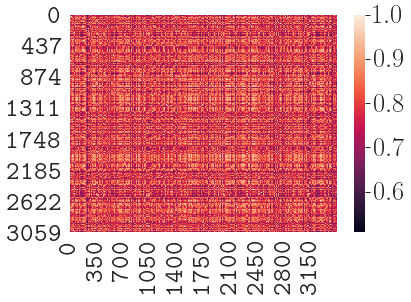

In [93]:
sns.heatmap(sim_matrix)

In [84]:
sim_matrix.shape

(3492, 3492)

In [ ]:
# pairwise_distances([[trip_id] for trip_id in trip_ids], metric = lambda x,y: get_wgm_similarity_50pt())
# sim_matrix = pairwise_distances(sample50df,metric=get_wgm_similarity_50pt,n_jobs=1)
# sim_matrix = pd.read_parquet(os.path.join(data_path_base, 'sim_matrix_scaled_frac0.02.parquet'))

-----

-------

### Attempting clustering

In [ ]:
sim_matrix_lkern = np.exp(-1 * sim_matrix  )

In [ ]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(sim_matrix,-1),norm_hist=False,label="raw similarity")
# ax =  sns.distplot(np.reshape(sim_matrix_lkern,-1),norm_hist=True,ax=ax,label="laplacian kernel")
ax.set_xlabel("similarity")
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density")
plt.legend(prop= {"size" : 18})
plt.show()

In [ ]:
xyt_columns = ['orig time','orig x','orig y','dest time','dest x','dest y']

In [101]:
pca_obj = PCA(n_components=3)

In [ ]:
pca_obj.fit(sampleODdf[xyt_columns])

In [ ]:
np.cumsum(pca_obj.explained_variance_ratio_)

In [97]:
n_clusters = 5

In [98]:
spc_obj = SpectralClustering(n_clusters = n_clusters, affinity='precomputed',n_jobs=-1,assign_labels="discretize",random_state=54321)

In [99]:
spc_obj.fit(sim_matrix)

SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=10, n_jobs=-1, n_neighbors=10, random_state=54321)

In [100]:
Counter(spc_obj.labels_)

Counter({0: 815, 4: 547, 2: 762, 3: 671, 1: 697})

In [ ]:
pca_projection = pca_obj.transform(sampleODdf[xyt_columns])

In [ ]:
# cmap = plt.cm.get_cmap('jet', 24)

In [ ]:
# mpl.colors.to_hex(cmap(5))

In [ ]:
# mpl.rcParams['font.family'] = 'sans-serif'

Per below cell, first component is more focused on longitute while the second component is a combination of latitute and time (for both origin and destination points).

In [ ]:
pca_obj.components_

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj.labels_,
                style=spc_obj.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('bright')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [ ]:
from sklearn.manifold import spectral_embedding

In [ ]:
spc_embedding = spectral_embedding(sim_matrix,n_components=2)

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_embedding[:,0]*100,spc_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj.labels_,
                     hue_order=range(n_clusters),
                     style=spc_obj.labels_,
                     style_order = range(n_clusters),
                     legend=False,
                     palette=sns.color_palette('bright')[:n_clusters]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

In [ ]:
#For adjusting aesthetics of legend:
# borderpad          the fractional whitespace inside the legend border
# labelspacing       the vertical space between the legend entries
# handlelength       the length of the legend handles
# handletextpad      the pad between the legend handle and text
# borderaxespad      the pad between the axes and legend border
# columnspacing      the spacing between columns

In [ ]:
from scipy.sparse import csgraph
from numpy import linalg as LA
L = csgraph.laplacian(sim_matrix, normed=True)
eigenvalues, eigenvectors = LA.eig(L)

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=eigenvalues[:10],x=range(10),s=36)
plt.ylabel('Eigenvalues')# of Normalized Laplacian')

In [ ]:
eigenvalues

In [ ]:
index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:5]

In [ ]:
index_largest_gap + 1

In [ ]:
%matplotlib notebook
sns.set_style('white')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_projection[:,0],pca_projection[:,1],pca_projection[:,2],
           s=6,
           c=[sns.color_palette('bright')[i] for i in spc_obj.labels_],)
ax.set_xlabel('PC1')
ax.xaxis.labelpad = 30
ax.set_ylabel('PC2')
ax.yaxis.labelpad = 30
ax.set_zlabel('PC3')
ax.zaxis.labelpad = 20
plt.show()

In [ ]:
%matplotlib inline

-----

----

Plot every point?

In [ ]:
# pca_projection_all = pca_obj.transform(OD)

In [ ]:
# plt.figure(figsize=(28,18))
# plt.scatter(pca_projection_all[:,0],pca_projection_all[:,1],s=0.1)
# plt.show()

------

Let's try a simple euclidean distance in R^6

In [ ]:
eucl_dist = pairwise_distances(sampleODdf[xyt_columns],metric='euclidean')

In [ ]:
euc_sim = 1/(1+eucl_dist)

In [ ]:
ax =  sns.distplot(np.reshape(euc_sim,-1),norm_hist=False,label="raw similarity")

In [ ]:
spc_obj_eucl = SpectralClustering(n_clusters=n_clusters,affinity='rbf')

In [ ]:
spc_obj_eucl.fit(sampleODdf[xyt_columns])

In [ ]:
Counter(spc_obj_eucl.labels_)

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj_eucl.labels_,
                style=spc_obj_eucl.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('husl')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [ ]:
spc_eucl_embedding = spectral_embedding(np.exp(-2 * eucl_dist ** 2),n_components=2)

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_eucl_embedding[:,0]*100,spc_eucl_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj_eucl.labels_,
                     hue_order=range(n_clusters),
                     style=spc_obj_eucl.labels_,
                     style_order = range(n_clusters),
                     legend=False,
                     palette=sns.color_palette('husl')[:n_clusters]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

In [ ]:
def get_ellipse(cluster,clr):
    data_x = cluster['orig x'].append(cluster['dest x'])
    data_y = cluster['orig y'].append(cluster['dest y'])

    avg_x = np.mean(data_x)
    avg_y = np.mean(data_y)
    x_diff = data_x - avg_x
    y_diff = data_y - avg_y
    x_diff_sq = [i**2 for i in x_diff]
    slope = sum(x*y for x,y in zip(x_diff,y_diff)) / sum(x_diff_sq)
    return(Ellipse((avg_x,avg_y),3*data_x.std(),3*data_y.std(),math.degrees(math.atan(slope)),facecolor='none',lw=1,edgecolor=clr))

In [ ]:
def get_ellipses_figure(ODdf, cluster_labels, color_palette=None):
    n_cluster = len(set(cluster_labels))
#     colors = [mpl.colors.to_hex(cmap(i/n_cluster)) for i in range(n_cluster)]
    if not color_palette:
        colors = sns.color_palette("bright", n_cluster)
    else:
        colors = color_palette
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111,aspect='equal')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    for i in range(n_cluster):
        cluster = ODdf[cluster_labels == i]
        sample_cluster = cluster.sample(100)
        sns.scatterplot(x = sample_cluster['orig x'],y=sample_cluster['orig y'], color=[colors[i]], alpha=1, marker='x', s=30, label='trip origins')
        sns.scatterplot(x = sample_cluster['dest x'],y=sample_cluster['dest y'], color=[colors[i]], alpha=0.4, s=12, label='trip destination')
#         ax.scatter(np.mean(cluster['orig x']),np.mean(cluster['orig y']),c=[colors[i]])
#         ax.scatter(np.mean(cluster['dest x']),np.mean(cluster['dest y']),c=[colors[i]],marker='s')
        ax.add_artist(get_ellipse(cluster,colors[i]))
    ax.set_xlabel("Scaled longitute",fontsize=22)
    ax.set_ylabel("Scaled latitude",fontsize=22)
    ax.get_legend().remove()
    return ax

In [ ]:
# sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
# sns.set_palette("bright")
# mpl.rcParams['font.family'] = ['monospace']

In [ ]:
get_ellipses_figure(sampleODdf, spc_obj.labels_)

In [ ]:
get_ellipses_figure(sampleODdf, spc_obj_eucl.labels_, sns.color_palette("husl", n_clusters))

In [ ]:
# ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']
# sampleODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [ ]:
def get_kdes_for_times(ODdf, cluster_labels, colors = None):
    n_cluster = len(set(cluster_labels))
    fig = plt.figure(figsize=(14,10))

    g = sns.JointGrid(x=ODdf['orig time'],y=ODdf['dest time'], height =10)
    if colors is None:
        colors = sns.color_palette("bright", n_cluster)
#     colors = ['blue','red','purple','green']
#     colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
    for i in range(n_cluster):
        cluster = ODdf[cluster_labels == i]
        sns.kdeplot(cluster['orig time'],cluster['dest time'],
                          shade=True,
                          shade_lowest=False,
                          legend=True,
                          color=colors[i],
                          ax=g.ax_joint)        
#         print(len(g.ax_joint.collections))
        sns.distplot(cluster['orig time'], kde=False, color=colors[i], ax=g.ax_marg_x, label='orig time')
        sns.distplot(cluster['dest time'], kde=False, color=colors[i], ax=g.ax_marg_y, vertical=True, label='dest time')
    for coll in g.ax_joint.collections:
        if coll.get_alpha() is None:
            coll.set_alpha(0.5)
#     g.ax_joint.collections[0].set_alpha(0)
#     g.ax_joint.collections[10].set_alpha(0)
#     g.ax_joint.collections[19].set_alpha(0)
#     g.ax_joint.collections[29].set_alpha(0)
    g.ax_marg_x.set_xlabel('')
    g.ax_marg_y.set_ylabel('')
    return g


In [ ]:
# sns.set_context('paper',font_scale=3)
get_kdes_for_times(sampleODdf, spc_obj.labels_)
plt.show()

In [ ]:
get_kdes_for_times(sampleODdf, spc_obj_eucl.labels_, colors=sns.color_palette("husl", n_clusters))
plt.show()

Let's define some sort of label for trips so that we can measure against!

In [ ]:
sampleODdf['orig x grid'] = (sampleODdf['orig x']*10).astype(np.int)
sampleODdf['orig y grid'] = (sampleODdf['orig y']*10).astype(np.int)
sampleODdf['dest x grid'] = (sampleODdf['dest x']*10).astype(np.int)
sampleODdf['dest y grid'] = (sampleODdf['dest y']*10).astype(np.int)
sampleODdf['orig time slot'] = (sampleODdf['orig time']*8).astype(np.int)
sampleODdf['dest time slot'] = (sampleODdf['dest time']*8).astype(np.int)
sampleODdf['orig grid id'] = sampleODdf['orig x grid'] * 10 + sampleODdf['orig y grid']
sampleODdf['dest grid id'] = sampleODdf['dest x grid'] * 10 + sampleODdf['dest y grid']
sampleODdf['wgm label'] = spc_obj.labels_
sampleODdf['eucl label'] = spc_obj_eucl.labels_

In [ ]:
sampleODdf

In [ ]:
#group can be either grid orig dest pair or time orig dest pair (with a label column as well)
def label_coverage_per_group(group_label_df, label_column = 'wgm label'):
    most_common_label = Counter(group_label_df[label_column]).most_common(1)[0]
    return most_common_label[1]/len(group_label_df)

In [ ]:
wgm_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id']).apply(label_coverage_per_group)

In [ ]:
eucl_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id']).apply(lambda x: label_coverage_per_group(x,'eucl label'))

In [ ]:
np.mean(eucl_most_common_ratios_per_grid),np.std(eucl_most_common_ratios_per_grid)

In [ ]:
np.mean(wgm_most_common_ratios_per_grid), np.std(wgm_most_common_ratios_per_grid)

In [ ]:
wgm_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot']).apply(label_coverage_per_group)

In [ ]:
eucl_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot']).apply(lambda x: label_coverage_per_group(x,'eucl label'))

In [ ]:
np.mean(wgm_most_common_ratios_per_time),np.std(wgm_most_common_ratios_per_time)

In [ ]:
np.mean(eucl_most_common_ratios_per_time),np.std(eucl_most_common_ratios_per_time)

In [ ]:
np.random.seed(54321)
confusion_per_n_cluster = []
for n_clusters in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    confusion_per_repeat = []
    for repeat in range(3):
        spc_obj = SpectralClustering(n_clusters = n_clusters, affinity='precomputed',n_jobs=1,assign_labels="kmeans")
        spc_obj_eucl = SpectralClustering(n_clusters=n_clusters,affinity='rbf')
        spc_obj.fit(sim_matrix)
        spc_obj_eucl.fit(sampleODdf[xyt_columns])
        sampleODdf['wgm label'] = spc_obj.labels_
        sampleODdf['eucl label'] = spc_obj_eucl.labels_
        wgm_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id'])\
                                                    .apply(label_coverage_per_group)
        eucl_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id'])\
                                                     .apply(lambda x: label_coverage_per_group(x,'eucl label'))
        wgm_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot'])\
                                                    .apply(label_coverage_per_group)
        eucl_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot'])\
                                                     .apply(lambda x: label_coverage_per_group(x,'eucl label'))
        
        confusion_per_repeat.append([np.mean(wgm_most_common_ratios_per_grid),np.mean(eucl_most_common_ratios_per_grid),
                                     np.mean(wgm_most_common_ratios_per_time),np.mean(eucl_most_common_ratios_per_time),
                                     np.std(wgm_most_common_ratios_per_grid),np.std(eucl_most_common_ratios_per_grid),
                                     np.std(wgm_most_common_ratios_per_time),np.std(eucl_most_common_ratios_per_time)])
    confusion_per_n_cluster.append(np.mean(confusion_per_repeat,axis=0))
    print('n_cluster {} done'.format(n_clusters))

In [ ]:
np.array(confusion_per_n_cluster)

In [ ]:
for row in confusion_per_n_cluster:
    print('{:.2f}+-{:.2f}  {:.2f}-+{:.2f}  {:.2f}+-{:.2f}  {:.2f}+-{:.2f}'.format(row[0],row[4],row[1],row[5],row[2],row[6],row[3],row[7]))

In [ ]:
pd.DataFrame(np.array(confusion_per_n_cluster))#,columns=['wgm grid coverage','eucl grid coverage',])